## Chapter 7 - Ensemble Learning and Random Forests

## Boosting

Recall that bagging creates multiple copies of the original training set by performing bootstrap sampling. Each tree is built on a bootstrap dataset, independent of the other trees. <u>Boosting</u> is similar but each tree is grown sequentially: each tree is grown using information from previously grown trees. 

The most popular methods for boosting are Adaboost and Gradient Boost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier, 
                              ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier)

from sklearn.datasets import make_moons

In [2]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Adaboost

To build an Adaptive Boosting (Adaboost) classifier, first determine the number of predictors, $B$. A base classifier $\hat{f^1}(x)$, say a Decision Tree model is trained using the training set. Then, $\hat{f^1}(x)$ is used to make predictions on the training set. Naturally, there will be correctly predicted instances and wrongly predicted instances. The relative weight of misclassified training instances is then increased. 

A second classifier, $\hat{f^2}(x)$, another decision tree model is trained using the training set <u> but with the updated weights</u>. We can see that $\hat{f^2}(x)$ will perform better at the misclassified training instances due to $\hat{f^1}(x)$. It now is used to make predictions on the training set, the relative weights of misclassified training instances is increased again, and a third classifier $\hat{f^3}(x)$ is trained, and so on and so forth until $\hat{f^B}(x)$, the last classifier.

In building these $B$ classifiers, we can see that each new predictor corrects its predecessor by increasing the weights, and hence paying more attention to the training instances that its predecessor underfitted. This results in predictors focusong more and more of the wrongly classified cases.

The boosting approach learns slowly. We fit a tree using the current residuals, rather than the outcome $y$ as the response. We then add this new treed into the fitted function in order to update the residuals. By fitting small trees to the residuals, we slowly improve $\hat f$ in ares where it does not perform well. 

Generally, boosting has three parameters:

- The number of trees $B$. Note that boosting can overfit if $B$ is too large. Generally, $B$ is selected using cross-validation

- The learning rate $\lambda$. This controls the rate at which boosting learns. Typical values are small like 0.01 or 0.001.

- The number of splits of each tree, $d$. 

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, but predictors that have different weights depending on their overall accuracy on the weighted training set.

In [3]:
# Train for Adaboost classifier
# B is n_estimators, 
# lambda is learning_rate
# d is number of layers, indicating number of splits
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, 
                            learning_rate=0.5, algorithm='SAMME.R')
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)

A weight is applied to every example in the training data. Initially, they are all equal so $w^{(i)}=\frac 1m$. A first predictor is trained. The errors are calculated using the error rate $r$.

$$r = \frac{\sum_{i=1,\hat{y}^{(i)} \neq {y}^{(i)}}^M w^{(i)}}{\sum_{i=1}^M w^{(i)}}$$
The numerator is sum of weights of all incorrectly classified instances while the denominator is sum of weights of all instances.

The predictor's weight $\alpha$ is computed using $\eta \log \frac{1-r}{r}$ where $\eta$ is the learning rate.

Now, a second predictor is trained on the training set again. But the weights of the training set are adjusted so the examples correctly classified have a smaller weight and those that were wrongly classified have a larger weight. To do so, 

$$w_\text{new} = \begin{cases}\frac{w_\text{old} \exp(\alpha)}{\sum_i w^{(i)}} \text{ if classified correctly or }\hat{y}^{(i)} = {y}^{(i)}\\\frac{w_\text{old} \exp(-\alpha)}{\sum_i w^{(i)}} \text{ if classified incorrectly or }\hat{y}^{(i)} \neq {y}^{(i)}\end{cases}$$


With multiple predictors and weights, the predicted class is the one that receives the maximum score of the weighted votes. 

### Gradient Boosting

Gradient boosting, like Adaboost, works by adding predictors sequentially to the ensemble. However, instead of tweaking the weights of the instance, the method fits the new predcitor to the residual errors made by the previous predictor. Generally the algorithm is as follows:

Given the training data $X$ and the target values $y$, 
1. Determine the number of trees to build, $B$. Set residuals $r_i = y_i$ for the training set.
2. Repeatedly fit a tree $\hat{f^b}$ to the training data $(X, r)$. Add the new tree to the boosted model: $f(x) \leftarrow f(x) + \lambda \hat{f^b}(x)$. Update the residuals $r_i \leftarrow r_i - \lambda \hat{f^b}(x_i)$
3. Add this tree in step 2 to the overall boosted model.

In [4]:
# B = 3
# Fit f1
tree1 = DecisionTreeClassifier(max_depth=2)
tree1.fit(X_train, y_train)
yres1 = y_train - tree1.predict(X_train)

# Fit f2
tree2 = DecisionTreeClassifier(max_depth=2)
tree2.fit(X_train, yres1)
yres2 = yres1 - tree2.predict(X_train)

# Fit f2
tree3 = DecisionTreeClassifier(max_depth=2)
tree3.fit(X_train, yres2)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [5]:
# For testing
# print(tree1.predict(X_test[:1]))
# print(tree2.predict(X_test[:1]))
# print(tree3.predict(X_test[:1]))

In [6]:
# Predict using the boosted model
y_pred = sum([tree.predict(X_test[:1]) for tree in [tree1, tree2, tree3]])/len([tree1, tree2, tree3])
print([1 if y_pred>0.5 else 0])

[0]


Boosting learns slowly. In each step, the tree fits on the residuals rather than the outcome. This new decison tree is added to the fitted function to update the residuals. By fitting small trees, we slowly improve the ensemble model in areas that does not perform well. The shrinkage parameter / learning rate slows the process down event further, allowing other trees to shave off from the residuals. 

The following is SKLearn's implementation of the gradient boosting algorithm.

In [7]:
# Train for GradientBoosting classifier
gbt_clf = GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1.0)
gbt_clf.fit(X_train, y_train)
# Predict
y_pred = gbt_clf.predict(X_test)

In [8]:
# Train for GradientBoosting classifier
gbrt = GradientBoostingClassifier(max_depth=2, n_estimators=120, learning_rate=0.01)
gbrt.fit(X_train, y_train)
# Predict
y_pred = gbrt.predict(X_test)

To find the optimal number of trees, you can use early stopping. A simple way to see this is to use `staged_predict()`. It returns an iterator over the predictions made by the ensemble at each stage of the training.

In [9]:
# After every tree is built, find the MSE of the predictions of that particular ensemble.
errors = [mean_squared_error(y_test, y_pred_i) for y_pred_i in gbrt.staged_predict(X_test)]
print(errors[:30])

# Of the errors, find the trees that have made the minimum MSE.
best_n_estimators = np.argmin(errors)

# This means that best_n_estimators is 22. The best ensemble contains 22 trees.
print(best_n_estimators)

# Then use this number of trees as the best classifier.
gbrt_best = GradientBoostingClassifier(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

[0.472, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104, 0.104]
1


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [10]:
errors_df = pd.DataFrame({'i' : range(len(errors)), 'e' : errors})

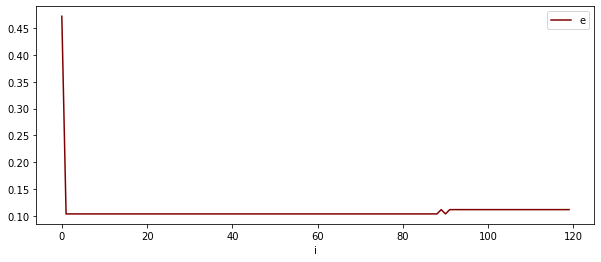

In [11]:
# Plotting for different alpha values
fig, ax = plt.subplots(figsize=(10,4))
errors_df.plot(kind='line', x='i', y='e', ax=ax, color='maroon')
plt.show()

Another way is to actually stop early:

In [12]:
# warm_start=True keeps existing trained trees after fit() is called
# subsample=0.25 means use only 25% of the training instances, sampled randomly
gbrt_growing = GradientBoostingClassifier(max_depth=2, warm_start=True, subsample=0.25) 
min_val_error = float('inf')

error_going_up = 0

# Stop training when the validation error does not improve for 5 consecutive iterations
for n_estimators in range(1, 120):
    gbrt_growing.n_estimators = n_estimators
    gbrt_growing.fit(X_train, y_train)
    y_pred = gbrt_growing.predict(X_test)
    validation_error = mean_squared_error(y_test, y_pred)
    print(validation_error)
    if validation_error < min_val_error:
        print('if')
        min_val_error = validation_error
        error_going_up = 0
    else:
        print('else')
        error_going_up +=1
        if error_going_up == 5:
            break
            
print(n_estimators)

0.168
if
0.168
else
0.12
if
0.136
else
0.128
else
0.12
else
0.128
else
0.12
else
8
